In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler 

# Data Preparation with Noise

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def introduce_symmetric_noise_inplace(dataset, noise_rate):
    labels = np.array(dataset.targets)
    num_classes = len(set(labels))
    n_samples = len(labels)
    n_noisy = int(noise_rate * n_samples)
    noisy_indices = np.random.choice(n_samples, n_noisy, replace=False)
    for idx in noisy_indices:
        current_label = labels[idx]
        new_label = np.random.choice([i for i in range(num_classes) if i != current_label])
        labels[idx] = new_label
    dataset.targets = labels.tolist()
    return dataset

def introduce_asymmetric_noise_inplace(dataset, noise_rate):
    
    asym_map = {
        0: 0,  # airplane -> airplane (stays same)
        1: 9,  # automobile -> truck
        9: 1,  # truck -> automobile
        2: 0,  
        3: 5,  
        5: 3,  
        4: 7,  
        6: 6,  
        7: 7,  
        8: 8   
    }

    labels = np.array(dataset.targets)
    n_samples = len(labels)

    # For each sample, let's flip label with probability noise_rate
    flip_mask = np.random.rand(n_samples) < noise_rate
    for i in range(n_samples):
        if flip_mask[i]:
            current_label = labels[i]
            labels[i] = asym_map[current_label]

    dataset.targets = labels.tolist()
    return dataset


noise_rates = [0.2, 0.4, 0.6, 0.8]
asymmetric_noise_rates = [0.1, 0.25, 0.4]

noisy_datasets = {}
for rate in noise_rates:
    dataset_copy = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    noisy_datasets[rate] = introduce_symmetric_noise_inplace(dataset_copy, rate)

asymmetric_noisy_datasets = {}
for rate in asymmetric_noise_rates:
    dataset_copy = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform
    )
    asymmetric_noisy_datasets[rate] = introduce_asymmetric_noise_inplace(dataset_copy, rate)

def get_dataloader(dataset, batch_size=64):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


noisy_dataloaders = {rate: get_dataloader(noisy_datasets[rate]) for rate in noise_rates}
asymmetric_noisy_dataloaders = {rate: get_dataloader(asymmetric_noisy_datasets[rate]) for rate in asymmetric_noise_rates}

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = get_dataloader(testset, batch_size=64)




Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Training CE on noise rate 0.2
Epoch 1 | Loss: 1.9593
Epoch 2 | Loss: 1.7814
Epoch 3 | Loss: 1.6920
Epoch 4 | Loss: 1.6281
Epoch 5 | Loss: 1.5783
Epoch 6 | Loss: 1.5257
Epoch 7 | Loss: 1.4810
Epoch 8 | Loss: 1.4391
Epoch 9 | Loss: 1.4040
Epoch 10 | Loss: 1.3621
Epoch 11 | Loss: 1.3280
Epoch 12 | Loss: 1.2895
Epoch 13 | Loss: 1.2540
Epoch 14 | Loss: 1.2157
Epoch 15 | Loss: 1.1823
Epoch 16 | Loss: 1.1395
Epoch 17 | Loss: 1.0939
Epoch 18 | Loss: 1.0570
Epoch 19 | Loss: 1.0109
Epoch 20 | Loss: 0.9684
Epoch 21 | Loss: 0.9312
Epoch 22 | Loss: 0.8918
Epoch 23 | Loss: 0.8611
Epoch 24 | Loss: 0.8431
Epoch 25 | Loss: 0.8305
CE Accuracy at 0.2 noise level: 78.86%
Training FL on noise rate 0.2
Epoch 1 | Loss: 1.4879
Epoch 2 | Loss: 1.3282
Epoch 3 | Loss: 1.2506
Epoch 4 | Loss: 1.2000
Epoch 5 | Loss: 1.1514
Epoch 6 | Loss: 1.1112
Epoch 7 | Loss: 1.0692
Epoch 8 | Loss: 1.0379
Epoch 9 | Loss: 1.0097
Epoch 10 | Loss: 0.9764
Epoch 11 | Loss: 0.9443
Epoch 12 | Loss: 0.9144
Epoch 13 | Loss: 0.8910
Epoch 1

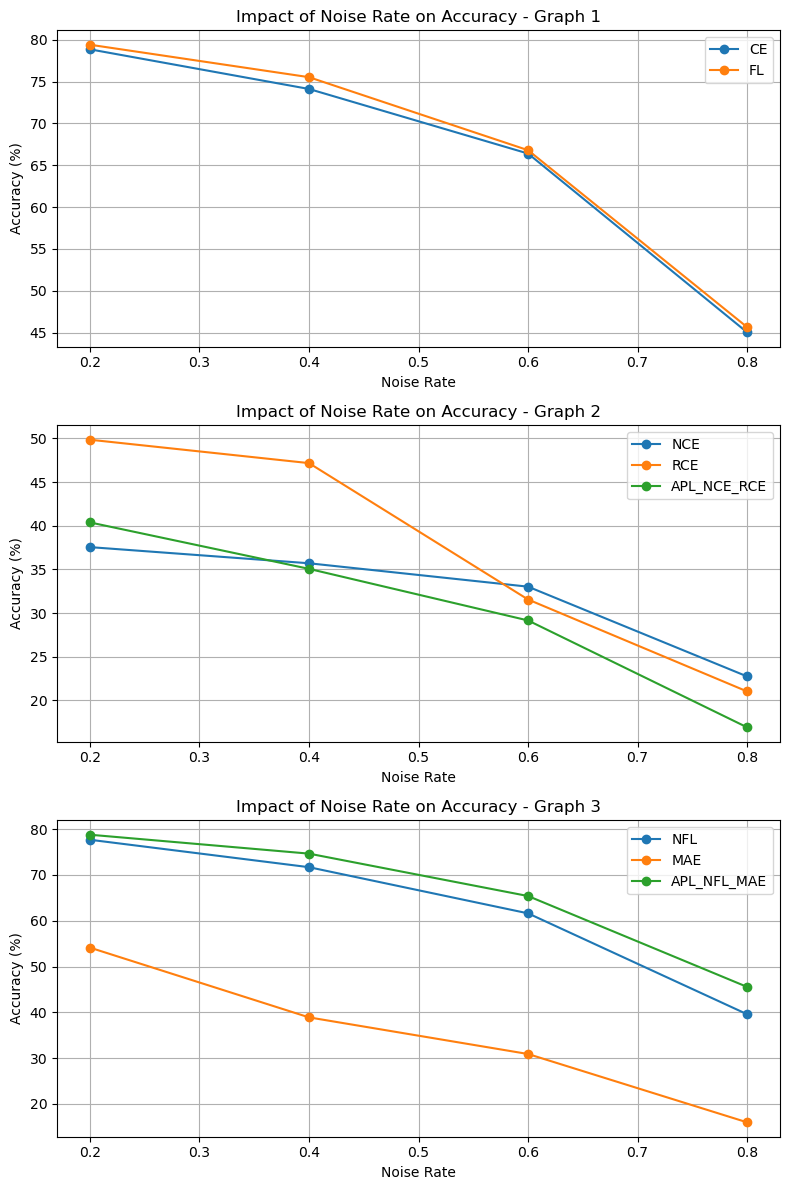

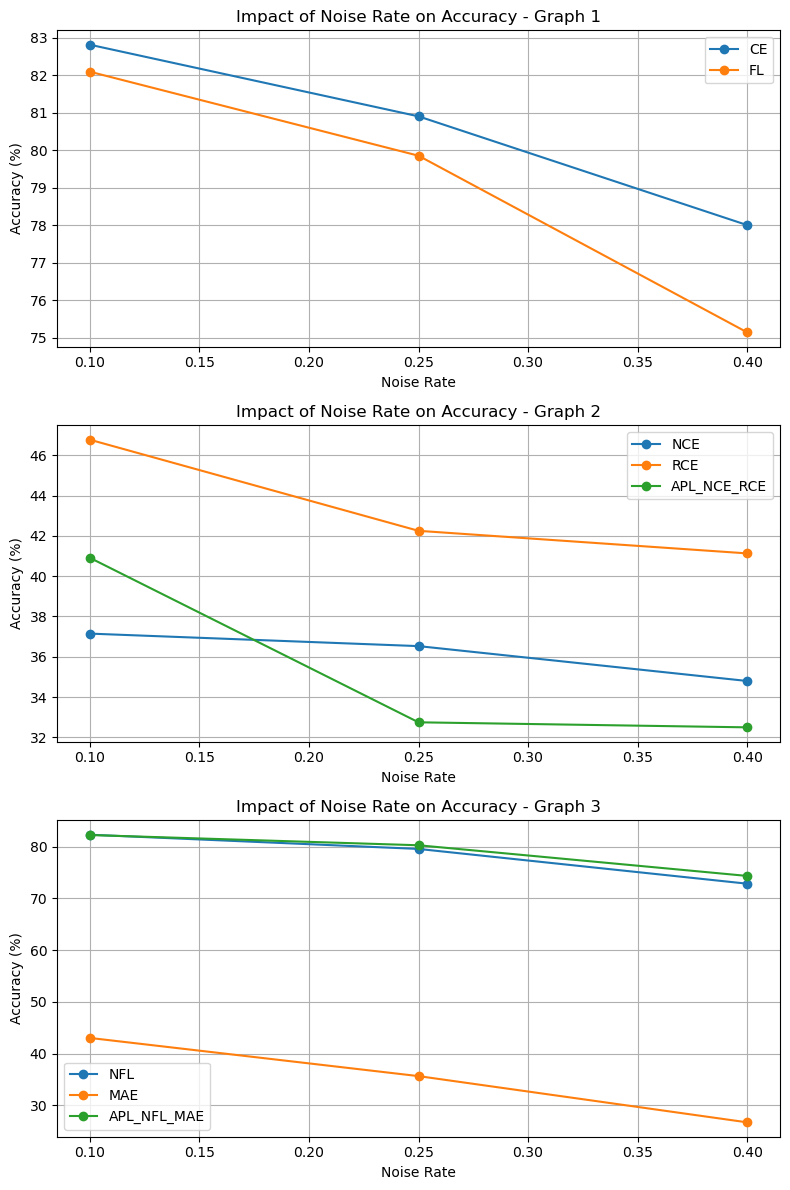

In [ ]:

# Model and Loss Function Definitions

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn_conv1 = nn.BatchNorm2d(128)
        self.bn_conv2 = nn.BatchNorm2d(128)
        self.bn_conv3 = nn.BatchNorm2d(256)
        self.bn_conv4 = nn.BatchNorm2d(256)
        self.dropout_conv = nn.Dropout2d(p=0.3)
        self.dropout = nn.Dropout(p=0.5)

        # Using a dummy tensor to compute the correct input size for fc1
        dummy_input = torch.zeros(1, 3, 32, 32)  
        out = self._get_conv_output(dummy_input)

        self.fc1 = nn.Linear(out, 1024)  # Dynamically determined
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def _get_conv_output(self, x):
        x = self.pool(F.relu(self.bn_conv1(self.conv1(x))))
        x = self.pool(F.relu(self.bn_conv2(self.conv2(x))))
        x = self.dropout_conv(x)
        x = self.pool(F.relu(self.bn_conv3(self.conv3(x))))
        x = self.pool(F.relu(self.bn_conv4(self.conv4(x))))
        x = self.dropout_conv(x)
        return int(torch.prod(torch.tensor(x.shape[1:])))  # Compute flattened size dynamically

    def forward(self, x):
        x = self.pool(F.relu(self.bn_conv1(self.conv1(x))))
        x = self.pool(F.relu(self.bn_conv2(self.conv2(x))))
        x = self.dropout_conv(x)
        x = self.pool(F.relu(self.bn_conv3(self.conv3(x))))
        x = self.pool(F.relu(self.bn_conv4(self.conv4(x))))
        x = self.dropout_conv(x)

        x = x.view(x.size(0), -1)  # Correctly flatten dynamically

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)


# Define Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

# Define Normalized Cross-Entropy Loss (NCE)
class NormalizedCrossEntropy(nn.Module):
    def __init__(self):
        super(NormalizedCrossEntropy, self).__init__()

    def forward(self, inputs, targets):
        """
        inputs:  [batch_size, num_classes] raw logits
        targets: [batch_size] integer class labels
        """
        batch_size = inputs.size(0)
        log_probs = F.log_softmax(inputs, dim=1)  # shape (B, C)

        # Numerator:  -log p(y|x)
        # i.e. the usual cross-entropy for the correct class only
        ce_per_sample = -log_probs[torch.arange(batch_size), targets]

        # Denominator: sum_k [-log p(k|x)]
        # i.e. the negative log-likelihood of all classes, then summed
        sum_neglog = -torch.sum(log_probs, dim=1)  # shape (B,)

        # Ratio
        ratio = ce_per_sample / (sum_neglog + 1e-12)

        return ratio.mean()

# Define Normalized Focal Loss (NFL)
class NormalizedFocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(NormalizedFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        num_classes = inputs.shape[1]
        normalization_factor = torch.log(torch.tensor(num_classes, dtype=torch.float, device=inputs.device) + 1e-8)

        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        focal_loss = focal_loss / normalization_factor  # Normalize final loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

# Define Mean Absolute Error (MAE) Loss 
class MAELoss(nn.Module):
    def __init__(self):
        super(MAELoss, self).__init__()

    def forward(self, inputs, targets):
        num_classes = inputs.shape[1]
        one_hot_targets = F.one_hot(targets, num_classes=num_classes).float()

        probs = F.softmax(inputs, dim=1)  # Convert logits to probabilities
        return torch.mean(torch.abs(one_hot_targets - probs))

# Define Reverse Cross-Entropy (RCE) Loss
class RCELoss(nn.Module):
    def __init__(self, A=-4.0):
        super(RCELoss, self).__init__()
        self.A = A  # clamp for log(0)

    def forward(self, inputs, targets):
        """
        inputs:  [batch_size, num_classes] raw logits
        targets: [batch_size] integer class labels
        """
        batch_size, num_classes = inputs.size()
        p = F.softmax(inputs, dim=1) 

        log_q = inputs.new_full((batch_size, num_classes), self.A)
        log_q[torch.arange(batch_size), targets] = 0.0

        rce_per_sample = -torch.sum(p * log_q, dim=1)
        return rce_per_sample.mean()


class APLLoss(nn.Module):
    
    def __init__(self, alpha_loss, passive_loss, alpha=1.0, beta=1.0):
        super(APLLoss, self).__init__()
        self.alpha_loss = alpha_loss   # e.g. NormalizedCrossEntropy() [active]
        self.passive_loss = passive_loss  # e.g. RCELoss() or MAELoss() [passive]
        self.alpha = alpha
        self.beta = beta

    def forward(self, outputs, labels):
        active_term = self.alpha_loss(outputs, labels)
        passive_term = self.passive_loss(outputs, labels)

        return self.alpha * active_term + self.beta * passive_term


loss_fns = {
    'CE': nn.CrossEntropyLoss(),
    'FL': FocalLoss(),
    'NCE': NormalizedCrossEntropy(),   # ratio-based NCE
    'NFL': NormalizedFocalLoss(),      # ratio-based NFL if you have it
    'MAE': MAELoss(),
    'RCE': RCELoss(A=-4.0),            # "true" reversed, with clamp
    'APL_NCE_RCE': APLLoss(NormalizedCrossEntropy(), RCELoss(A=-4.0)),
    'APL_NFL_MAE': APLLoss(NormalizedFocalLoss(), MAELoss()),
}

loss_lrs = {
    'CE': 0.01,       # Cross-Entropy (CE)
    'FL': 0.01,       # Focal Loss (FL)
    'NCE': 0.02,      # Normalized Cross-Entropy (NCE) (slightly higher due to normalization)
    'NFL': 0.02,      # Normalized Focal Loss (NFL)
    'MAE': 0.005,     # Mean Absolute Error (MAE) (lower as it's sensitive to scale)
    'RCE': 0.005,     # Reverse Cross-Entropy (RCE) (similar to MAE)
    'APL_NCE_RCE': 0.01,  # Active-Passive Loss with NCE + RCE
    'APL_NFL_MAE': 0.01   # Active-Passive Loss with NFL + MAE
}


def train_model(loss_fn, trainloader, lr, epochs=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleCNN().to(device)
    # Using SGD with momentum and weight decay
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    # Using a cosine annealing scheduler over the full number of epochs
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    loss_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        avg_loss = running_loss / len(trainloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")

    return model, loss_history



def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

results = {}
for noise_rate in noise_rates:
    noisy_trainloader = noisy_dataloaders[noise_rate]
    for loss_name, loss_fn in loss_fns.items():
        print(f"Training {loss_name} on noise rate {noise_rate}")
        model, losses = train_model(loss_fn, noisy_trainloader, loss_lrs[loss_name])
        acc = evaluate_model(model, testloader)
        results[(loss_name, noise_rate)] = (acc, losses)
        print(f"{loss_name} Accuracy at {noise_rate} noise level: {acc:.2f}%")
asymmetric_results = {}
for noise_rate in asymmetric_noise_rates:
    noisy_trainloader = asymmetric_noisy_dataloaders[noise_rate]
    for loss_name, loss_fn in loss_fns.items():
        print(f"[Asymmetric] Training {loss_name} at noise rate {noise_rate}")
        model, losses = train_model(loss_fn, noisy_trainloader, loss_lrs[loss_name])
        acc = evaluate_model(model, testloader)
        asymmetric_results[(loss_name, noise_rate)] = (acc, losses)
        print(f"[Asymmetric] {loss_name} Accuracy at {noise_rate} noise level: {acc:.2f}%")



import matplotlib.pyplot as plt

def plot_results(results, noise_rates, loss_fns):
    loss_names = list(loss_fns.keys())

    groups = [
        loss_names[:2],  
        [loss_names[2], loss_names[5], loss_names[6]],  
        [loss for loss in loss_names if loss not in loss_names[:2] and loss not in [loss_names[2], loss_names[5], loss_names[6]]]  # Remaining
    ]

    plt.figure(figsize=(8, 12))

    for i, group in enumerate(groups, 1):
        plt.subplot(3, 1, i)
        for loss_name in group:
            accuracies = [results[(loss_name, noise_rate)][0] for noise_rate in noise_rates]
            plt.plot(noise_rates, accuracies, marker='o', label=loss_name)

        plt.xlabel("Noise Rate")
        plt.ylabel("Accuracy (%)")
        plt.title(f"Impact of Noise Rate on Accuracy - Graph {i}")
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()

plot_results(results, noise_rates, loss_fns)
plot_results(asymmetric_results, asymmetric_noise_rates, loss_fns)
